* Deletions
* HG002 Only
* Technology: 250bp

* The following classifier will train on and predict the following labels:
    - GTcons
    

In [4]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [5]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/train/tech_sep/DEL/250bp_HG002_DEL.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/train/tech_sep/DEL/250bp_HG002_DEL.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,refN_cnt,refN_pct,...,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_insertSizeScore,Ill250.ref_reason_orientation
0,1,39,HG002,109690878,109690918,Insertion,Deletion,-39,0,0,...,8.0,0.0,966.62069,38.728421,29.0,454.896552,102.198031,29.0,NaN,0.0


In [6]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/test/tech_sep/DEL/250bp_HG002_DEL.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Sept122017/Step3_ML/data/test/tech_sep/DEL/250bp_HG002_DEL.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,refN_cnt,refN_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,5,1,HG002,15411043,15411104,Insertion,Deletion,-60,0,0,...,0.0,5.0,0.0,982.8,9.846827,5.0,404.2,80.434818,5.0,0.0


In [7]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Ill250.ref_reason_insertSizeScore', 'Label'}

In [8]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Ill250.ref_reason_insertSizeScore'], axis=1, inplace = True)
df_train.drop(['Label'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [9]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1,109690878,109690918,-39,0,0,0,0.0,1,0.4,...,2.0,8.0,0.0,966.62069,38.728421,29.0,454.896552,102.198031,29.0,0.0


In [10]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [11]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict', 'GTsupp', 'SVtype', 'id', 'sample', 'type'}

In [12]:
### Drop columns that are not shared by both dataframes
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [13]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1,109690878,109690918,-39,0,0,0,0.000000,1,0.4,...,2.0,8.0,0.0,966.62069,38.728421,29.0,454.896552,102.198031,29.0,0.0
1,1,1869280,1869312,-31,0,0,0,0.000000,0,0.0,...,0.0,5.0,0.0,978.00000,27.434337,28.0,448.500000,62.304838,28.0,0.0
2,1,2891239,2891284,-44,0,0,1,0.666667,1,1.0,...,0.0,10.0,2.0,994.00000,0.000000,1.0,424.000000,0.000000,1.0,0.0


In [14]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/2340 with 2 missing, elapsed time: 1.590
Imputing row 101/2340 with 2 missing, elapsed time: 1.651
Imputing row 201/2340 with 2 missing, elapsed time: 1.660
Imputing row 301/2340 with 2 missing, elapsed time: 1.668
Imputing row 401/2340 with 2 missing, elapsed time: 1.676
Imputing row 501/2340 with 2 missing, elapsed time: 1.686
Imputing row 601/2340 with 2 missing, elapsed time: 1.694
Imputing row 701/2340 with 2 missing, elapsed time: 1.703
Imputing row 801/2340 with 2 missing, elapsed time: 1.711
Imputing row 901/2340 with 2 missing, elapsed time: 1.719
Imputing row 1001/2340 with 2 missing, elapsed time: 1.727
Imputing row 1101/2340 with 2 missing, elapsed time: 1.736
Imputing row 1201/2340 with 2 missing, elapsed time: 1.744
Imputing row 1301/2340 with 2 missing, elapsed time: 1.752
Imputing row 1401/2340 with 0 missing, elapsed time: 1.758
Imputing row 1501/2340 with 0 missing, elapsed time: 1.763
Imputing row 1601/2340 with 0 missing, elapsed time: 1.768
Imputing 

In [15]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,1.0,109690878.0,109690918.0,-39.0,0.0,0.0,0.0,0.000000,1.0,0.4,...,2.0,8.0,0.0,966.62069,38.728421,29.0,454.896552,102.198031,29.0,0.0
1,1.0,1869280.0,1869312.0,-31.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,5.0,0.0,978.00000,27.434337,28.0,448.500000,62.304838,28.0,0.0
2,1.0,2891239.0,2891284.0,-44.0,0.0,0.0,1.0,0.666667,1.0,1.0,...,0.0,10.0,2.0,994.00000,0.000000,1.0,424.000000,0.000000,1.0,0.0


In [16]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y['GTcons'] = X['GTcons']

In [17]:
#Count the number of labels
pd.value_counts(Y['GTcons'].values, sort=False)

 1.0     642
-1.0     368
 2.0     154
 0.0    1176
dtype: int64

In [18]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [19]:
# Remove labels from feature set
X.drop(['GTcons'],axis=1, inplace = True)

In [20]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

** Train RF Classifier **

In [21]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [22]:
# %%timeit
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



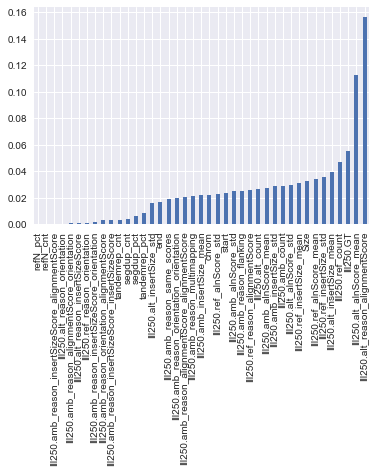

In [23]:
# Feature Importance
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot.bar()

In [24]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

 1.0    337
-1.0    129
 2.0     92
 0.0    568
dtype: int64

In [25]:
model.predict(X_test)

array([ 0.,  0.,  1.,  1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  0.,  1.,  2.,  1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  1.,
       -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  1.,
        0.,  1.,  0., -1., -1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0., -1.,  1.,  0.,  0., -1.,  1.,  0.,
        1., -1.,  0.,  0.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  1.,  0.,  0.,  2.,  0., -1.,  0.,  2., -1.,  0.,  0., -1.,
        1.,  0., -1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0., -1.,  1.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0

In [26]:
pred = model.predict(X_test)

In [27]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(pred, y_test, average='micro'))) 

Precision score of the training subset: 0.699


In [28]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,Size,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
1980,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,885.460396,...,-41.0,4.0,38598858.0,0.0,0.0,0.0,0.0,38598817.0,1.0,0.073171
2078,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,858.403727,...,-475.0,5.0,179065925.0,0.0,0.0,0.0,0.0,179065450.0,2.0,0.080000
9,-1.0,921.925926,36.731182,27.0,403.740741,85.140665,27.0,0.0,0.0,832.234637,...,-20.0,1.0,24220960.0,0.0,0.0,0.0,0.0,24220939.0,1.0,1.000000
1117,-1.0,977.750000,7.790218,4.0,492.000000,57.436922,4.0,0.0,0.0,891.851282,...,-22.0,4.0,187058131.0,0.0,0.0,0.0,0.0,187058108.0,1.0,1.000000
195,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,864.094340,...,-232.0,15.0,71991778.0,0.0,0.0,0.0,0.0,71991545.0,2.0,0.197425


In [29]:
labels = pd.DataFrame(y_test)

In [30]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTcons'] = df_train['GTcons']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [31]:
pd.value_counts(df_Xtest['GTcons'].values, sort=False)

 0    352
 1    189
 2     46
-1    115
dtype: int64

In [32]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

 0.0    362
 1.0    232
-1.0     93
 2.0     15
dtype: int64

In [33]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTcons']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[ 37  29  44   5]
 [ 26 313  13   0]
 [ 24  18 139   8]
 [  6   2  36   2]]


In [34]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,2.0,All
True,,,,,
-1,37,29,44,5,115
0,26,313,13,0,352
1,24,18,139,8,189
2,6,2,36,2,46
All,93,362,232,15,702


In [35]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

             precision    recall  f1-score   support

         -1       0.40      0.32      0.36       115
          0       0.86      0.89      0.88       352
          1       0.60      0.74      0.66       189
          2       0.13      0.04      0.07        46

avg / total       0.67      0.70      0.68       702



***
Predict
***

** Load Data **

In [36]:
X2 = df_test

** Impute missing values using KNN **

In [37]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/4995 with 1 missing, elapsed time: 7.761
Imputing row 101/4995 with 1 missing, elapsed time: 7.769
Imputing row 201/4995 with 1 missing, elapsed time: 7.778
Imputing row 301/4995 with 1 missing, elapsed time: 7.785
Imputing row 401/4995 with 1 missing, elapsed time: 7.793
Imputing row 501/4995 with 1 missing, elapsed time: 7.805
Imputing row 601/4995 with 1 missing, elapsed time: 7.813
Imputing row 701/4995 with 1 missing, elapsed time: 7.827
Imputing row 801/4995 with 1 missing, elapsed time: 7.840
Imputing row 901/4995 with 1 missing, elapsed time: 7.851
Imputing row 1001/4995 with 1 missing, elapsed time: 7.867
Imputing row 1101/4995 with 1 missing, elapsed time: 7.883
Imputing row 1201/4995 with 1 missing, elapsed time: 7.895
Imputing row 1301/4995 with 1 missing, elapsed time: 7.912
Imputing row 1401/4995 with 1 missing, elapsed time: 7.925
Imputing row 1501/4995 with 1 missing, elapsed time: 7.936
Imputing row 1601/4995 with 1 missing, elapsed time: 7.944
Imputing 

In [38]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,5.0,15411043.0,15411104.0,-60.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,0.0,5.0,0.0,982.8,9.846827,5.0,404.2,80.434818,5.0,0.0
1,7.0,158112624.0,158112712.0,-88.0,0.0,0.0,0.0,0.0,2.0,0.715909,...,0.0,5.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,4.0,95498964.0,95499280.0,-316.0,0.0,0.0,0.0,0.0,1.0,0.117089,...,0.0,2.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [39]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,Ill250.amb_reason_orientation_alignmentScore,Ill250.amb_reason_orientation_orientation,Ill250.amb_reason_same_scores,Ill250.ref_alnScore_mean,Ill250.ref_alnScore_std,Ill250.ref_count,Ill250.ref_insertSize_mean,Ill250.ref_insertSize_std,Ill250.ref_reason_alignmentScore,Ill250.ref_reason_orientation
0,5.0,15411043.0,15411104.0,-60.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,0.0,5.0,0.0,982.8,9.846827,5.0,404.2,80.434818,5.0,0.0
1,7.0,158112624.0,158112712.0,-88.0,0.0,0.0,0.0,0.0,2.0,0.715909,...,0.0,5.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,4.0,95498964.0,95499280.0,-316.0,0.0,0.0,0.0,0.0,1.0,0.117089,...,0.0,2.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [40]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [41]:
model.predict(X5)

array([ 1.,  1.,  1., ...,  1.,  0.,  0.])

In [42]:
pred = model.predict(X5)

In [43]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']

In [44]:
X5.head(3)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp
0,-1.0,939.000000,61.408468,6.0,370.666667,82.463460,5.0,0.0,1.0,891.040179,...,0.0,0.0,0.0,0.0,15411043,1.0,1.000000,1.0,-1,0
1,-1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,770.978261,...,0.0,0.0,0.0,0.0,158112624,2.0,0.715909,1.0,-1,0
2,2.0,980.534884,24.312260,43.0,444.790698,85.191046,42.0,1.0,0.0,863.292398,...,0.0,0.0,0.0,0.0,95498964,1.0,0.117089,1.0,2,1


***
Label Analysis
***

In [45]:
df_new = pd.DataFrame()
df_new['true'] = df_test_2['GTcons'].astype(float)
df_new['predicted'] = pred
df_new['predicted'] = df_new['predicted'].astype(float)

In [46]:
pd.value_counts(df_new['true'].values, sort=False)

-1.0    1491
 2.0     671
 1.0    1912
 0.0     921
dtype: int64

In [47]:
pd.value_counts(df_new['predicted'].values, sort=False)

 1.0    3125
 0.0    1068
-1.0     574
 2.0     228
dtype: int64

In [48]:
# Calculate Precision Score
true = df_new['true']
predicted = df_new['predicted']
print('Precision score of the test subset: {:.3f}'.format(precision_score(predicted, true, average='micro'))) 

Precision score of the test subset: 0.591


In [49]:
pd.crosstab(true, predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1.0,0.0,1.0,2.0,All
True,,,,,
-1.0,292,226,926,47,1491
0.0,76,817,25,3,921
1.0,162,22,1696,32,1912
2.0,44,3,478,146,671
All,574,1068,3125,228,4995


* Note: Low model precision score (~57%). This may be due in part to the model being trained on and predicting -1 values

* Next step: Trained and predicted labels in a new model without -1 in the following notebook[] 

** Exact Match **

In [50]:
em = X5['predicted_label'] == 1.0
exact_match = X5[em]

In [51]:
exact_match.head(1)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp
0,-1.0,939.0,61.408468,6.0,370.666667,82.46346,5.0,0.0,1.0,891.040179,...,0.0,0.0,0.0,0.0,15411043,1.0,1.0,1.0,-1,0


In [52]:
output_notebook()
p = figure()
p = Histogram(exact_match, values='GTcons', title='Exact_Match_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

Loading BokehJS ...

** Homozygous Reference **

In [53]:
hr = X5['predicted_label'] == 0.0
hom_ref = X5[hr]
hom_ref.head(1)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp
6,-1.0,936.333333,41.611964,3.0,431.666667,76.058457,3.0,0.0,0.0,883.65,...,0.0,0.0,0.0,0.0,64676299,1.0,1.0,0.0,-1,0


In [54]:
output_notebook()
p = figure()
p = Histogram(hom_ref, values='GTcons', title='Homozygous_Reference_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

Loading BokehJS ...

** Inaccurate Call **

In [55]:
ic = X5['predicted_label'] == 2.0
inac_call = X5[ic]
inac_call.head(1)

,Ill250.GT,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,...,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp
18,2.0,979.108696,13.304508,46.0,438.891304,105.755302,46.0,0.0,0.0,863.974093,...,0.0,0.0,0.0,0.0,27278795,1.0,1.0,2.0,-1,0


In [56]:
output_notebook()
p = figure()
p = Histogram(inac_call, values='GTcons', title='Inaccurate_Call_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

Loading BokehJS ...